In [1]:

import os
import re
import torch
import torchaudio
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import umap
from datetime import datetime
from IPython.display import display, Markdown


AUDIO_DIR = "/media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/train_soundscapes/"   
EMBEDDING_DIR="/media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1"
os.makedirs(EMBEDDING_DIR, exist_ok=True)


In [2]:
FILENAME_PATTERN = re.compile(r"(?P<site>[A-Z0-9]+)_(?P<date>\d{8})_(?P<time>\d{6})\.ogg$")

def get_unlabeled_audio_data(directory):
    audio_files_info = []
    for filename in os.listdir(directory):
        if filename.endswith(".ogg"):
            match = FILENAME_PATTERN.match(filename)
            if match:
                site = match.group("site")
                date = match.group("date")
                time = match.group("time")
                timestamp = datetime.strptime(f"{date}_{time}", "%Y%m%d_%H%M%S")
                audio_files_info.append({
                    "filename": filename,
                    "site": site,
                    "datetime": timestamp,
                    "path": os.path.join(directory, filename)
                })
    return audio_files_info

audio_data = get_unlabeled_audio_data(AUDIO_DIR)
display(Markdown(f"**Found `{len(audio_data)}` OGG files.**"))


**Found `9726` OGG files.**

In [3]:
# Loading the HuBERT and preprocessing transforms

bundle = torchaudio.pipelines.HUBERT_BASE
model = bundle.get_model().eval()

resampler = T.Resample(orig_freq=48000, new_freq=16000)
def preprocess_waveform(waveform, sample_rate):
    if sample_rate != 16000:
        waveform = resampler(waveform)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)  # Downmix to mono
    return waveform


In [4]:
#  Generate and Save HuBERT Embeddings

def generate_and_save_embeddings(audio_files):
    for item in audio_files:
        path = item["path"]
        save_path = os.path.join(EMBEDDING_DIR, item["filename"].replace(".ogg", ".pt"))
        if os.path.exists(save_path):
            continue  # Already processed
        try:
            waveform, sr = torchaudio.load(path)
            waveform = preprocess_waveform(waveform, sr)
            with torch.inference_mode():
                features, _ = model(waveform)
            torch.save(features, save_path)
            print(f"✔️ Saved: {save_path}")
        except Exception as e:
            print(f"❌ Failed: {path} | {e}")

generate_and_save_embeddings(audio_data)


✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/H26_20230515_110000.pt
✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/O203_20230521_122000.pt
✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/O203_20230521_164500.pt
✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/O203_20230521_171000.pt
✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/O203_20230521_172500.pt
✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/O203_20230522_064500.pt
✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/O203_20230522_190000.pt
✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/O203_20230522_200500.pt
✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/O203_20230523_011500.pt
✔️ Saved: /media/siddhantp/TOSHIBA EXT/birdclef-2025 (1)/hubert_embeddings1/O203_20230523_151500.pt
✔

In [5]:
#Load and pool embeddings for UMAP

def load_all_embeddings(audio_files):
    all_embeddings = []
    labels = []
    for item in audio_files:
        embed_path = os.path.join(EMBEDDING_DIR, item["filename"].replace(".ogg", ".pt"))
        if os.path.exists(embed_path):
            embedding = torch.load(embed_path)
            pooled = torch.mean(embedding.squeeze(0), dim=0)  # Mean pooling
            all_embeddings.append(pooled.numpy())
            labels.append(item["site"])
    return np.array(all_embeddings), labels

X, sites = load_all_embeddings(audio_data)
print(f"Loaded {len(X)} embeddings.")


Loaded 9726 embeddings.


In [16]:
!pip install umap-learn

DEPRECATION: Loading egg at /home/siddhantp/anaconda3/lib/python3.11/site-packages/ianvs-0.1.0-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
    PyYAML (>=5.1.*)
            ~~~~~~^

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/home/siddhantp/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/siddhantp/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


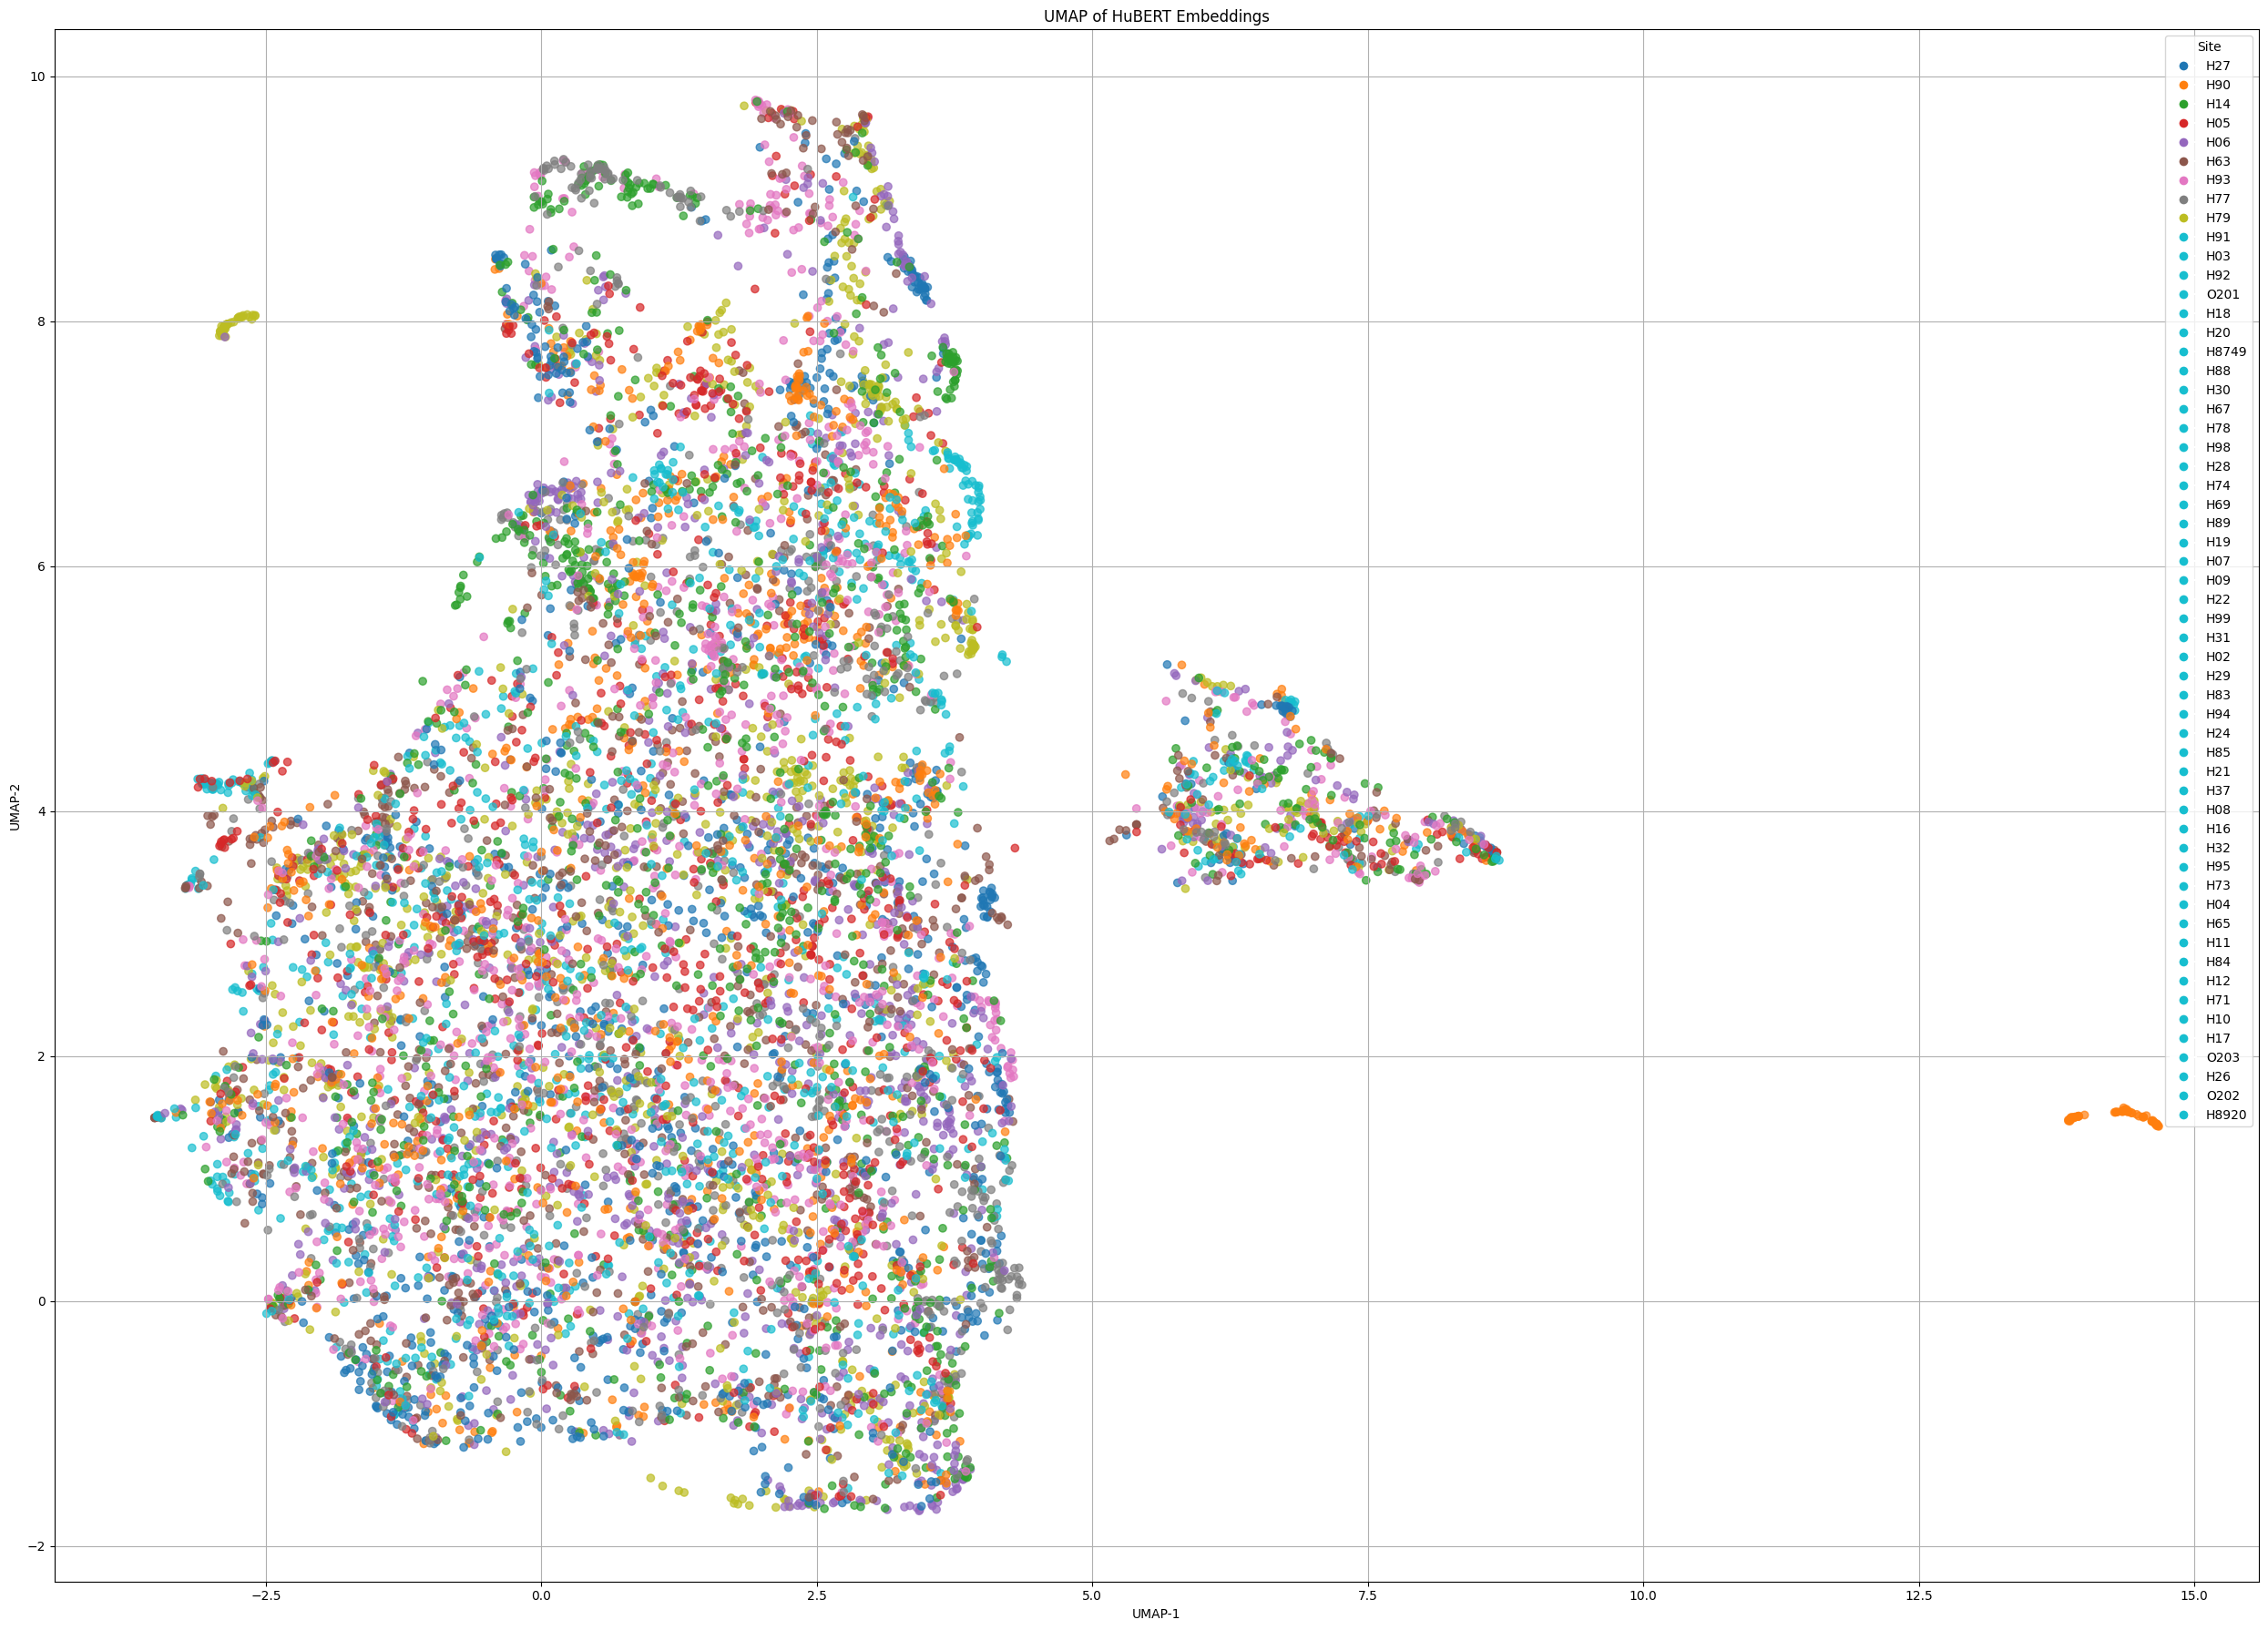

In [21]:
# UMAP Visualization

import umap.umap_ as umap


def visualize_umap(embeddings, labels):
    reducer = umap.UMAP(random_state=42)
    embedding_2d = reducer.fit_transform(embeddings)

    unique_sites = list(set(labels))
    color_map = {site: i for i, site in enumerate(unique_sites)}
    colors = [color_map[l] for l in labels]

    plt.figure(figsize=(25, 18))
    scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=colors, cmap='tab10', alpha=0.7)
    handles = [plt.Line2D([], [], marker='o', color='w', label=s, 
                          markerfacecolor=plt.cm.tab10(i/10.0), markersize=8)
               for i, s in enumerate(unique_sites)]
    plt.legend(handles=handles, title="Site")
    plt.title("UMAP of HuBERT Embeddings")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_umap(X, sites)
